In [1]:
import pandas as pd
import tensorflow as tf
import tensorflow.keras.layers as tfl
from tensorflow.keras.datasets.mnist import load_data
import numpy as np
import matplotlib.pyplot as plt

# Data

We will test each model on MNIST classification.

In [2]:
data = load_data()

In [3]:
X_train = data[0][0]
y_train = data[0][1]
X_test = data[1][0]
y_test = data[1][1]

In [4]:
X_train = np.expand_dims(X_train, axis=3)
X_test = np.expand_dims(X_test, axis=3)

In [5]:
def one_hot(y, n):
    temp = np.zeros((len(y), n))
    for i in range(len(y)):
        temp[i, y[i]] = 1
    return temp

y_train = one_hot(y_train, 10)
y_test = one_hot(y_test, 10)

# Models

In [6]:
def first_n(model, X, y, n):
    n = np.sqrt(n)
    if int(n)!=n:
        raise ValueError("Invalid n. Must be a perfect square.")
    else:
        n = int(n)
        fig, ax = plt.subplots(n,n, figsize = (10*n/3,10*n/3))
        for i in range(n):
            for j in range(n):
                targ = np.argmax(y[n*i+j])
                img = X[n*i+j]
                pred = np.argmax(model.predict(np.expand_dims(img, axis = 0)))
                ax[i][j].imshow(img)
                ax[i][j].set_title(f"Target = {targ}, Prediction = {pred}")
                ax[i][j].get_xaxis().set_ticklabels([])
                ax[i][j].get_yaxis().set_ticklabels([])

## LeNet5:

In [7]:
def LeNet5(input_shape):
    in_img = tf.keras.Input(shape = input_shape)
    out = tfl.Conv2D(kernel_size = 5, filters = 6, padding = "valid", activation = "sigmoid")(in_img)
    out = tfl.AvgPool2D(pool_size = 2, strides = 2)(out)
    out = tfl.Conv2D(kernel_size = 5, filters = 16, padding = "valid", activation = "sigmoid")(out)
    out = tfl.AvgPool2D(pool_size = 2, strides = 2)(out)
    out = tfl.Flatten()(out)
    out = tfl.Dense(input_shape = out.shape, units = 120, activation = "sigmoid")(out)
    out = tfl.Dense(input_shape = out.shape, units = 84, activation = "sigmoid")(out)
    out = tfl.Dense(input_shape = out.shape, units = 10, activation = "softmax")(out)
    model = tf.keras.Model(inputs=in_img, outputs=out)
    return model

In [8]:
LeNet5_model = LeNet5((X_train[0].shape))
LeNet5_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 24, 24, 6)         156       
_________________________________________________________________
average_pooling2d (AveragePo (None, 12, 12, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 16)          2416      
_________________________________________________________________
average_pooling2d_1 (Average (None, 4, 4, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 120)               30840 

In [9]:
LeNet5_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
histories = []
history = LeNet5_model.fit(X_train, y_train, epochs = 3, validation_data = (X_test, y_test))
histories.append(history)

Epoch 1/3
1875/1875 [==============================] - 22s 11ms/step - loss: 1.0773 - accuracy: 0.6572 - val_loss: 0.1379 - val_accuracy: 0.9592
Epoch 2/3
1875/1875 [==============================] - 17s 9ms/step - loss: 0.1340 - accuracy: 0.9596 - val_loss: 0.0857 - val_accuracy: 0.9740
Epoch 3/3
1875/1875 [==============================] - 19s 10ms/step - loss: 0.0945 - accuracy: 0.9710 - val_loss: 0.0741 - val_accuracy: 0.9761


In [10]:
LeNet5_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
histories = []
history = LeNet5_model.fit(X_train, y_train, epochs = 10, validation_data = (X_test, y_test))
histories.append(history)

Epoch 1/10
1875/1875 [==============================] - 19s 10ms/step - loss: 0.0772 - accuracy: 0.9761 - val_loss: 0.0627 - val_accuracy: 0.9807
Epoch 2/10
1875/1875 [==============================] - 18s 9ms/step - loss: 0.0642 - accuracy: 0.9799 - val_loss: 0.0498 - val_accuracy: 0.9844
Epoch 3/10
1875/1875 [==============================] - 18s 10ms/step - loss: 0.0589 - accuracy: 0.9822 - val_loss: 0.0443 - val_accuracy: 0.9860
Epoch 4/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.0502 - accuracy: 0.9844 - val_loss: 0.0449 - val_accuracy: 0.9854
Epoch 5/10
1875/1875 [==============================] - 18s 9ms/step - loss: 0.0428 - accuracy: 0.9865 - val_loss: 0.0381 - val_accuracy: 0.9876
Epoch 6/10
1875/1875 [==============================] - 18s 9ms/step - loss: 0.0384 - accuracy: 0.9879 - val_loss: 0.0394 - val_accuracy: 0.9870
Epoch 7/10
1875/1875 [==============================] - 18s 9ms/step - loss: 0.0365 - accuracy: 0.9883 - val_loss: 0.0470 - val_

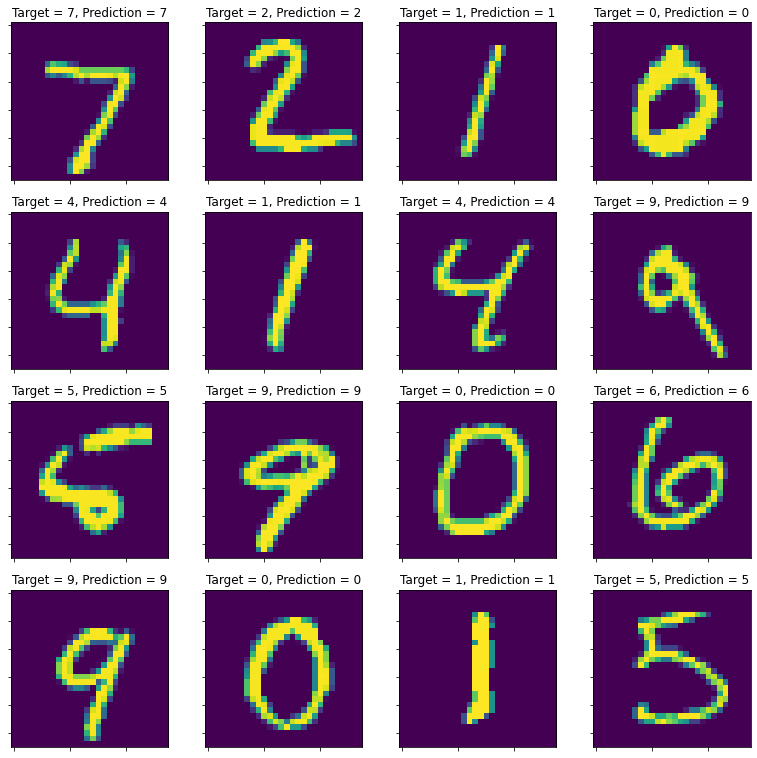

In [11]:
first_n(LeNet5_model, X_test, y_test, 16)

## ResNet

We will go for a ResNet with three residual blocks and pooling after the shortcut connections.

In [12]:
def residual_block(in_img, conv_size, pool_size, conv_stride, pool_stride, n_filters):
    out1 = tfl.Conv2D(kernel_size = conv_size, filters = n_filters, strides = conv_stride, padding = "same", activation = "relu")(in_img)
    out2 = tfl.Conv2D(kernel_size = conv_size, filters = n_filters, strides = conv_stride, padding = "same")(out1)
    out = tfl.ReLU()(out2+out1)
    out = tfl.MaxPool2D(pool_size = pool_size, strides = pool_stride)(out)
    return out

In [13]:
def ResNet(input_shape):
    in_img = tf.keras.Input(shape = input_shape)
    out = residual_block(in_img, 3, 2, 1, 2, 8)
    out = residual_block(out, 3, 2, 1, 2, 16)
    out = tfl.Flatten()(out)
    out = tfl.Dense(input_shape = out.shape, units = 120, activation = "sigmoid")(out)
    out = tfl.Dense(input_shape = out.shape, units = 84, activation = "sigmoid")(out)
    out = tfl.Dense(input_shape = out.shape, units = 10, activation = "softmax")(out)
    model = tf.keras.Model(inputs=in_img, outputs=out)
    return model

In [14]:
ResNet_model = ResNet((X_train[0].shape))
ResNet_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 28, 28, 8)    80          input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 28, 28, 8)    584         conv2d_2[0][0]                   
__________________________________________________________________________________________________
tf.__operators__.add (TFOpLambd (None, 28, 28, 8)    0           conv2d_3[0][0]                   
                                                                 conv2d_2[0][0]             

In [15]:
ResNet_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
history = ResNet_model.fit(X_train, y_train, epochs = 10, validation_data = (X_test, y_test))
histories.append(history)

Epoch 1/10
1875/1875 [==============================] - 51s 27ms/step - loss: 0.8542 - accuracy: 0.7864 - val_loss: 0.1900 - val_accuracy: 0.9457
Epoch 2/10
1875/1875 [==============================] - 47s 25ms/step - loss: 0.1606 - accuracy: 0.9536 - val_loss: 0.1148 - val_accuracy: 0.9640
Epoch 3/10
1875/1875 [==============================] - 51s 27ms/step - loss: 0.1381 - accuracy: 0.9564 - val_loss: 0.1104 - val_accuracy: 0.9655
Epoch 4/10
1875/1875 [==============================] - 49s 26ms/step - loss: 0.1523 - accuracy: 0.9517 - val_loss: 0.1218 - val_accuracy: 0.9640
Epoch 5/10
1875/1875 [==============================] - 49s 26ms/step - loss: 0.1548 - accuracy: 0.9507 - val_loss: 0.1250 - val_accuracy: 0.9592
Epoch 6/10
1875/1875 [==============================] - 49s 26ms/step - loss: 0.1360 - accuracy: 0.9582 - val_loss: 0.1123 - val_accuracy: 0.9660
Epoch 7/10
1875/1875 [==============================] - 49s 26ms/step - loss: 0.1265 - accuracy: 0.9610 - val_loss: 0.1042 -

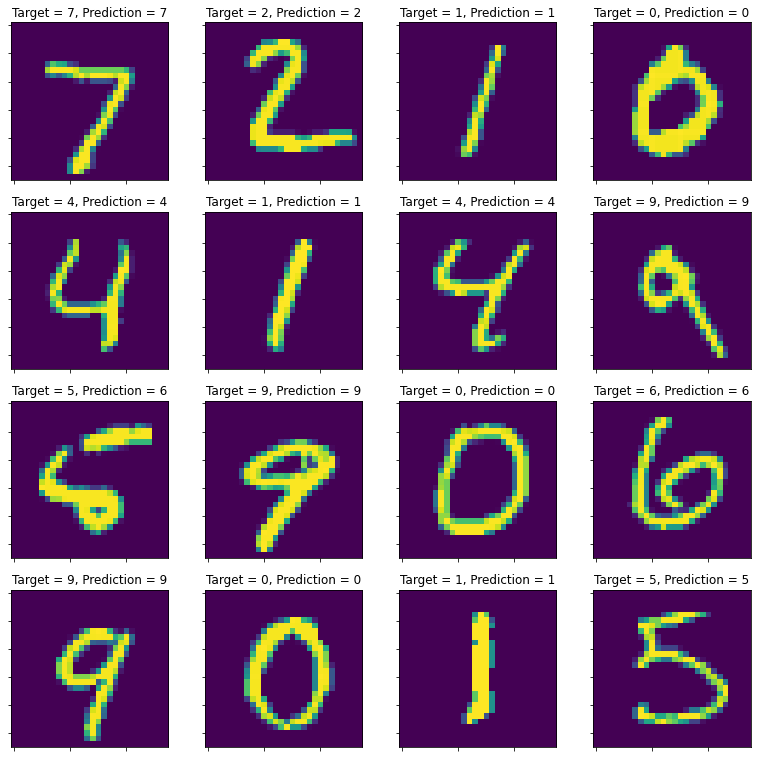

In [16]:
first_n(ResNet_model, X_test, y_test, 16)

## Inception Network

In [17]:
def inception_block(in_img, n_filters, start1d = None):
    if start1d:
        in_img = tfl.Conv2D(kernel_size = 1, filters = start1d, strides = 1, padding = "same", activation = "relu")(in_img)
    out1 = tfl.Conv2D(kernel_size = 1, filters = n_filters[0], strides = 1, padding = "same", activation = "relu")(in_img)
    out2 = tfl.Conv2D(kernel_size = 3, filters = n_filters[1], strides = 1, padding = "same", activation = "relu")(in_img)
    out3 = tfl.Conv2D(kernel_size = 5, filters = n_filters[2], strides = 1, padding = "same", activation = "relu")(in_img)
    out4 = tfl.MaxPool2D(pool_size = 2, strides = 1,padding = "same")(in_img)
    out = tf.keras.layers.Concatenate(axis=3)([out1,out2,out3,out4])
    out = tfl.MaxPool2D(pool_size = 2, strides = 2)(out)
    return out

In [18]:
def InceptionNet(input_shape):
    in_img = tf.keras.Input(shape = input_shape)
    out = inception_block(in_img, [32, 64, 16])
    out = inception_block(out, [32, 64, 16], start1d = 8)
    out = tfl.Flatten()(out)
    out = tfl.Dense(input_shape = out.shape, units = 120, activation = "sigmoid")(out)
    out = tfl.Dense(input_shape = out.shape, units = 84, activation = "sigmoid")(out)
    out = tfl.Dense(input_shape = out.shape, units = 10, activation = "softmax")(out)
    model = tf.keras.Model(inputs=in_img, outputs=out)
    return model

In [19]:
InceptionNet_model = InceptionNet((X_train[0].shape))
InceptionNet_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 28, 28, 32)   64          input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 28, 28, 64)   640         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 28, 28, 16)   416         input_3[0][0]                    
____________________________________________________________________________________________

In [20]:
InceptionNet_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
history = InceptionNet_model.fit(X_train, y_train, epochs = 10, validation_data = (X_test, y_test))
histories.append(history)

Epoch 1/10
1875/1875 [==============================] - 131s 69ms/step - loss: 1.2032 - accuracy: 0.6630 - val_loss: 0.2769 - val_accuracy: 0.9070
Epoch 2/10
1875/1875 [==============================] - 152s 81ms/step - loss: 0.3153 - accuracy: 0.9076 - val_loss: 0.2663 - val_accuracy: 0.9197
Epoch 3/10
1875/1875 [==============================] - 124s 66ms/step - loss: 0.3069 - accuracy: 0.9062 - val_loss: 0.2985 - val_accuracy: 0.9051
Epoch 4/10
1875/1875 [==============================] - 128s 68ms/step - loss: 0.3279 - accuracy: 0.9005 - val_loss: 0.3085 - val_accuracy: 0.9065
Epoch 5/10
1875/1875 [==============================] - 143s 76ms/step - loss: 0.3045 - accuracy: 0.9063 - val_loss: 0.2467 - val_accuracy: 0.9239
Epoch 6/10
1875/1875 [==============================] - 139s 74ms/step - loss: 0.2899 - accuracy: 0.9121 - val_loss: 0.2214 - val_accuracy: 0.9315
Epoch 7/10
1875/1875 [==============================] - 133s 71ms/step - loss: 0.2542 - accuracy: 0.9220 - val_loss: 0

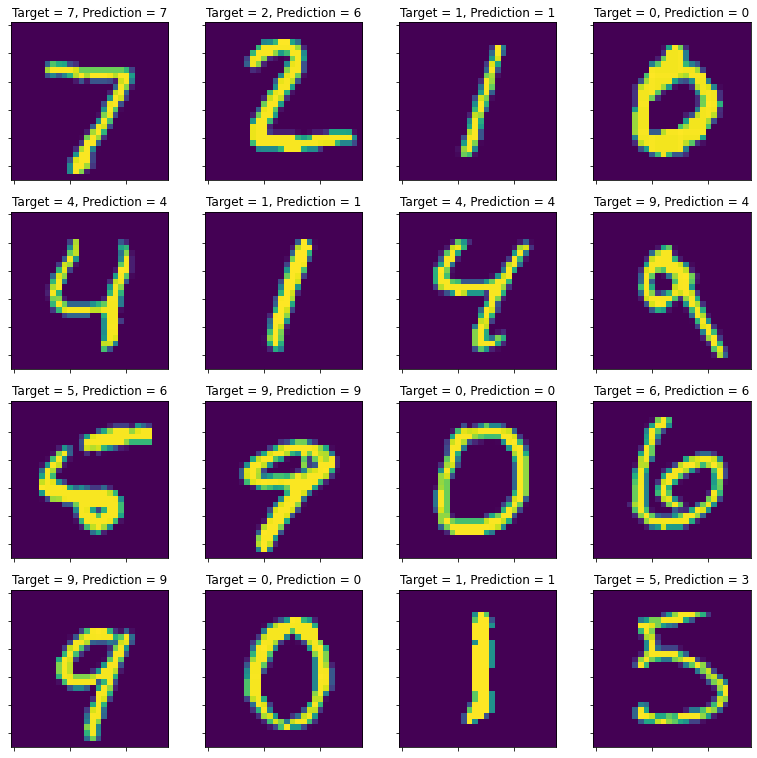

In [21]:
first_n(InceptionNet_model, X_test, y_test, 16)

## MobileNet

In [22]:
def DepthwiseSeparableConv2D(in_img, n_filters, kernel_size, stride, padding):
    depthwise = []
    for i in range(in_img.shape[3]):
        expand_layer = tf.keras.layers.Lambda(lambda x: tf.expand_dims(x[:,:,:,i], axis = 3))
        img = expand_layer(in_img)
        depthwise.append(tfl.Conv2D(kernel_size = kernel_size, filters = 1, strides = stride, padding = padding)(img))
    if len(depthwise)>1:
        out = tf.keras.layers.Concatenate(axis=3)(depthwise)
    else:
        out = depthwise[0]
    out = tfl.Conv2D(kernel_size = 1, filters = n_filters, strides = 1, padding = "same", activation = "sigmoid")(out)
    return out

In [23]:
def MobileNet(input_shape):
    in_img = tf.keras.Input(shape = input_shape)
    out = DepthwiseSeparableConv2D(in_img, 6, 5, stride = 1, padding = "valid")
    out = tfl.MaxPool2D(pool_size = 2, strides = 2)(out)
    out = DepthwiseSeparableConv2D(out, 16, 5, stride = 1, padding = "valid")
    out = tfl.MaxPool2D(pool_size = 2, strides = 2)(out)
    out = tfl.Flatten()(out)
    out = tfl.Dense(input_shape = out.shape, units = 120, activation = "sigmoid")(out)
    out = tfl.Dense(input_shape = out.shape, units = 84, activation = "sigmoid")(out)
    out = tfl.Dense(input_shape = out.shape, units = 10, activation = "softmax")(out)
    model = tf.keras.Model(inputs=in_img, outputs=out)
    return model

In [24]:
MobileNet_model = MobileNet((X_train[0].shape))
MobileNet_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 28, 28, 1)    0           input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 24, 24, 1)    26          lambda[0][0]                     
__________________________________________________________________________________________________
conv2d_14 (Conv2D)              (None, 24, 24, 6)    12          conv2d_13[0][0]                  
____________________________________________________________________________________________

In [25]:
MobileNet_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
history = MobileNet_model.fit(X_train, y_train, epochs = 10, validation_data = (X_test, y_test))
histories.append(history)

# Look into time not being quicker than LeNet

Epoch 1/10
1875/1875 [==============================] - 35s 17ms/step - loss: 1.4391 - accuracy: 0.5069 - val_loss: 0.3283 - val_accuracy: 0.8917
Epoch 2/10
1875/1875 [==============================] - 32s 17ms/step - loss: 0.3199 - accuracy: 0.8974 - val_loss: 0.2229 - val_accuracy: 0.9318
Epoch 3/10
1875/1875 [==============================] - 33s 18ms/step - loss: 0.2279 - accuracy: 0.9277 - val_loss: 0.1944 - val_accuracy: 0.9372
Epoch 4/10
1875/1875 [==============================] - 34s 18ms/step - loss: 0.1890 - accuracy: 0.9394 - val_loss: 0.1541 - val_accuracy: 0.9504
Epoch 5/10
1875/1875 [==============================] - 35s 19ms/step - loss: 0.1500 - accuracy: 0.9532 - val_loss: 0.1102 - val_accuracy: 0.9646
Epoch 6/10
1875/1875 [==============================] - 32s 17ms/step - loss: 0.1083 - accuracy: 0.9662 - val_loss: 0.1346 - val_accuracy: 0.9578
Epoch 7/10
1875/1875 [==============================] - 27s 14ms/step - loss: 0.1004 - accuracy: 0.9685 - val_loss: 0.0870 -

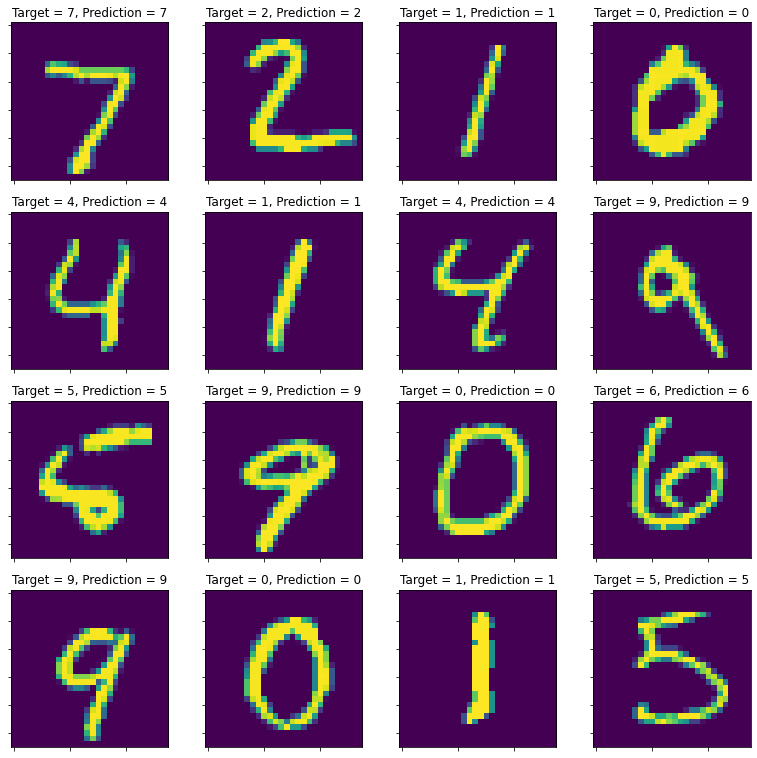

In [26]:
first_n(MobileNet_model, X_test, y_test, 16)

# Comparison

In [27]:
histories = [pd.DataFrame(h.history) for h in histories]

In [28]:
models = ["LeNet", "ResNet", "InceptionNet", "MobileNet"]


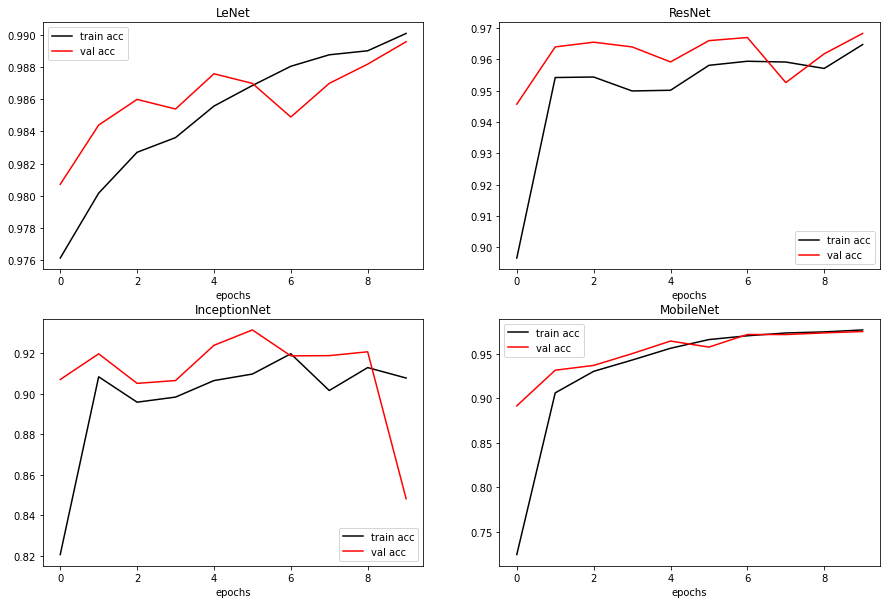

In [29]:
fig, ax = plt.subplots(2,2, figsize = (15,10))
for i in range(2):
    for j in range(2):
        ax[i][j].plot(histories[2*i+j].accuracy.values, "k-", label = "train acc")
        ax[i][j].plot(histories[2*i+j].val_accuracy.values, "r-", label = "val acc")
        ax[i][j].set_title(models[2*i+j])
        ax[i][j].set_xlabel("epochs")
        ax[i][j].legend()

Text(0.5, 1.0, 'Validation Accuracy Across Models')

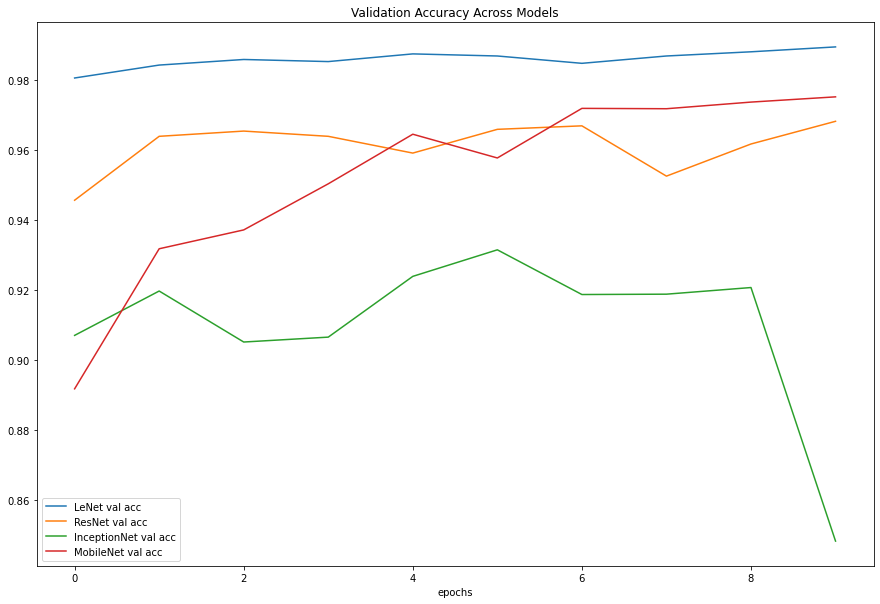

In [33]:
fig, ax = plt.subplots(1,1, figsize = (15,10))
for i in range(4):
    ax.plot(histories[i].val_accuracy.values, label = f"{models[i]} val acc")
ax.set_xlabel("epochs")
ax.legend()
ax.set_title("Validation Accuracy Across Models")